In [232]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END, add_messages

# When defining a graph, the first step is to define its State. 
# The State includes the graph's schema and reducer functions that handle state updates
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [233]:
import os
from langchain.chat_models import init_chat_model
with open('apikey.txt', mode='r') as file:
    apikey = file.read()

os.environ['OPENAI_API_KEY'] = apikey

llm = init_chat_model(
    model_provider = 'openai',
    model = "o4-mini" #"gpt-4.1-nano"
)

In [234]:
from langchain_core.tools import tool

# create tool
@tool
def my_name() -> str:
    """Returns the name of the human user.
    This tool should only be used if the human user asks the AI what their name is.
    If AI does not know the answer, then the AI should say they do not know."""
    return 'Bernie'

def num_homes_for_rent_in_Sydney() -> int:
    """Returns the number of available homes for rent in Sydney
    This tool should only be used if the human user asks the AI what the number of homes for rent is in Sydney.
    If AI does not know the answer, then the AI should say they do not know."""
    return 10

tools=[my_name, num_homes_for_rent_in_Sydney]
llm = llm.bind_tools(tools)


In [235]:
def chatbot(graphState: State) -> State:
    update = {'messages' : [llm.invoke(graphState['messages'])]}
    return update

graph_builder.add_node('chatbot', chatbot)

In [236]:
graph_builder.add_edge(START, 'chatbot')
#compiled_graph = graph_builder.compile()

In [237]:
from IPython.display import Image, display
from langgraph.graph import StateGraph

def display_graph(compiledGraph):
    """Displays a given compiled graph"""
    display(Image(compiledGraph.get_graph().draw_mermaid_png()))

In [238]:
# interactive chatbot but no memory
# input = 'what is my name?'
# for event in compiled_graph.stream({"messages": [{"role": "user", "content": input}]}):
#     print(event)
#     for i, value in enumerate(event.values()):
#         print(i)
#         print(value['messages'])
#         print("Assistant:", value["messages"][-1].content)



In [239]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tool_node", tool_node)

In [240]:
from langgraph.prebuilt import tools_condition
# add conditional edge
graph_builder.add_conditional_edges(
    'chatbot', # source
    tools_condition,
    path_map = {
        'tools' : 'tool_node', 
        END: END
    }
)

In [241]:
graph_builder.add_edge('tool_node', 'chatbot')

In [242]:
compiled_graph = graph_builder.compile()

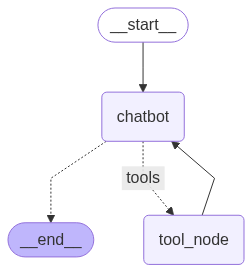

In [243]:
display_graph(compiled_graph)

In [245]:
while True:
    user_input = input('Prompt: ')
    print(f'User: {user_input}')
    if user_input in ['q', 'quit']:
        print('chatbot end')
        break

    for event in compiled_graph.stream(input = {'messages': [{'role' : 'user', 'content' : f'{user_input}'}]}):
        for value in event.values():
            print(f'Assistant: {value['messages'][-1].content}')


User: Hello chatbot
Assistant: Hello! How can I assist you today?
User: what is my name?
Assistant: 
Assistant: Bernie
Assistant: Your name is Bernie.
User: how many homes are their in Sydney to rent?
Assistant: 
Assistant: 10
Assistant: There are currently 10 homes available for rent in Sydney.
User: q
chatbot end
